In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '/astro/users/bmmorris/git/friedrich/')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris
from glob import glob

In [2]:
archive_paths = sorted(glob('/local/tmp/friedrich/hat11/chains???.hdf5'))
#archive_paths = sorted(glob('/local/tmp/friedrich/hat11_init/chains???.hdf5'))
print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris())
    all_times.extend(m.lc.times.jd)
    spots = m.get_spots()
    transits.append(Transit(spots))

load results


In [3]:
from friedrich.orientation import times_to_occulted_lat_lon
from astroML.plotting import plot_tissot_ellipse

transit_params = hat11_params_morris()

all_lats = []
all_lons = []
all_amps = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params, rotate_star=True)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
all_lats = np.array(all_lats)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

In [4]:
from friedrich.orientation import times_to_occulted_lat_lon

lats = np.zeros(len(all_times))#[]
lons = np.zeros(len(all_times))#[]
for i, t in enumerate(all_times):
    lat, lon = times_to_occulted_lat_lon(np.array([t]), transit_params, rotate_star=True)
    lats[i] = lat
    lons[i] = lon

/astro/users/bmmorris/git/friedrich/friedrich/orientation.py:383: RuntimeWarning: invalid value encountered in sqrt
  projected_z = np.sqrt(1 - x**2 - y**2)


In [5]:
bic_threshold = 20
sig_lats = all_lats[all_BICs > bic_threshold]
sig_lons= all_lons[all_BICs > bic_threshold]
sig_lats_times = all_spot_times[all_BICs > bic_threshold]
#fig, ax = plt.subplots(1, 2, figsize=(14, 5))

n_bins = 80
lon_grid = np.linspace(-np.pi, np.pi, n_bins)
lat_grid = np.linspace(-np.pi/2, np.pi/2, n_bins)

bins = np.zeros((n_bins, n_bins))
spots_in_visit_bin = np.zeros((n_bins, n_bins))
for i in range(n_bins-1):
    
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]

    visits_in_lon_bin = ((lons < lon_bin_upper) & 
                         (lons > lon_bin_lower))
    spots_in_lon_bin = ((sig_lons < lon_bin_upper) & 
                        (sig_lons > lon_bin_lower))
    
    for j in range(n_bins-1):
        
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]

        visits_in_lat_bin = ((lats < lat_bin_upper) & 
                      (lats > lat_bin_lower))
        
        bins[j, i] = np.count_nonzero(visits_in_lat_bin & 
                                      visits_in_lon_bin)

        spots_in_lat_bin = ((sig_lats < lat_bin_upper) & 
                            (sig_lats > lat_bin_lower))
        
        spots_in_visit_bin[j, i] = np.count_nonzero(spots_in_lon_bin &
                                              spots_in_lat_bin)

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in greater
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in greater


In [6]:
from matplotlib.patches import Polygon

def color_scale(x):
    return fraction_of_colorbar*(x - bins.min()) / bins.max()

def add_circle_patch(ax, radius, lat1, lon1, n_points=20, **kwargs):
    """
    add patch with circle of radius [rad] with lat/lon [radians]
    
    kwargs passed to matplotlib.patches.Polygon.
    
    Conversion formula discovered here: 
    http://williams.best.vwh.net/avform.htm#LL
    """
    d = radius
    thetas = np.linspace(0, -2*np.pi, n_points)[:, np.newaxis]

    lat = np.arcsin(np.sin(lat1) * np.cos(d) + np.cos(lat1) *
                    np.sin(d) * np.cos(thetas))
    dlon = np.arctan2(np.sin(thetas) * np.sin(d) * np.cos(lat1), 
                      np.cos(d) - np.sin(lat1) * np.sin(lat))

    lon = ((lon1 - dlon + np.pi) % (2*np.pi)) - np.pi
    xy = np.hstack([lon, lat])
    
    if (xy[:, 0].min() > np.radians(-170)) and (xy[:, 0].max() < np.radians(170)):
        # If circle isn't split between E/W-ern hemispheres: 
        polygon = Polygon(xy, True, rasterized=True, **kwargs)
        ax.add_patch(polygon)
    else:        
        # If circle is split between E/W-ern hemispheres,
        # plot western hemisphere first
        xy_1 = xy.copy()
        xy_1[:, 0][xy_1[:, 0] > 0] -= 2 * np.pi
        polygon_1 = Polygon(xy_1, True, rasterized=True, **kwargs)
        ax.add_patch(polygon_1)

        # then plot eastern hemisphere
        xy_2 = xy.copy()
        xy_2[:, 0][xy_2[:, 0] < 0] += 2 * np.pi
        polygon_2 = Polygon(xy_2, True, rasterized=True, **kwargs)
        ax.add_patch(polygon_2)
        
def custom_grid(ax, color='gray'):
    # plot latitude/longitude grid
    ax.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2, 2, 5)))
    ax.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
    ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
    ax.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))

    ax.grid(True, which='minor', color=color, ls=':')
    
    if color != 'gray':
        for l in ax.get_xticklabels():
            l.set_color(color)
        
def plot_colorbar(fig, ax):
    gradient = np.linspace(0, fraction_of_colorbar, 256)
    gradient = np.vstack(5*[gradient])

    ax.imshow(gradient, cmap=cmap, aspect=1.0, vmin=0, vmax=1) 
    ax.set_yticks([])
    nticks = 6
    axspace = np.linspace(0, 256, nticks)
    xticks = np.linspace(bins.min(), bins.max(), nticks).astype(int)
    ax.set_xticks(axspace)
    ax.set_xticklabels(xticks)

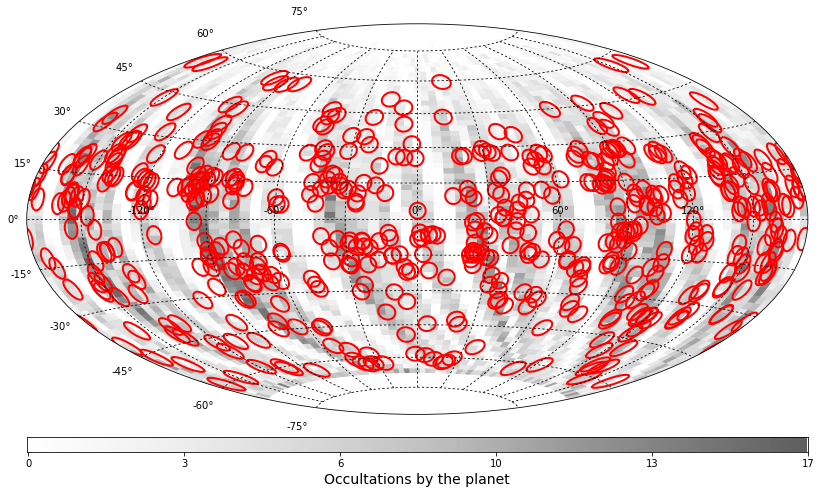

In [7]:
projection = 'Hammer'

cmap = plt.cm.Greys # plt.cm.copper
fraction_of_colorbar = 0.7
circle_color = 'r'
radius = 1.0*np.tan(transit_params.rp)

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())

for i in range(n_bins-1):
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]
    for j in range(n_bins-1):
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]
        
        # [lon min, lon max], [lat min, lat min], [lat max]
        ax.fill_between([lon_bin_lower, lon_bin_upper], 
                        [lat_bin_lower, lat_bin_lower], 
                        lat_bin_upper, 
                        color=cmap(color_scale(bins[j, i])))
    
ax2 = plt.subplot(212)
plot_colorbar(fig, ax2)
fig.subplots_adjust(hspace=-0.58)

# plot spots
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params, rotate_star=True)
        add_circle_patch(ax, transit_params.rp, latitude, longitude, 
                         facecolor='none', edgecolor=circle_color, lw=2,
                         alpha=1.0)
custom_grid(ax, color='k')
ax2.set_xlabel('Occultations by the planet', fontsize=14)
fig.savefig('plots/map_friedrich.png', bbox_inches='tight', dpi=200)

In [8]:
n_spots = len(sig_lats)
print(n_spots)

n_transits = 0
for transit in transits:
    transit_counted = False
    for spot in transit.spots: 
        if spot.delta_BIC >= 20:
            transit_counted = True
            
    if transit_counted:
        n_transits += 1
        
print(n_transits)

294
140


In [9]:
import json

class SpotParams(object):
    def __init__(self, r, theta, phi, time=None,
                 delta_chi2=None, flag=None, theta_err=None, 
                 r_upper=None, r_lower=None, phi_err=None, name=None):
        self.r = r
        self.theta = theta
        self.phi = phi
        self.time = time
        self.delta_chi2 = delta_chi2
        self.flag = flag
       
        self.r_lower = r_lower
        self.r_upper = r_upper
        self.phi_err = phi_err
        self.theta_err = theta_err
        self.name = name
        
    def to_dict(self):
        return dict(r=self.r, theta=self.theta, phi=self.phi, 
                    r_upper=self.r_upper, theta_err=self.theta_err, phi_err=self.phi_err, 
                    r_lower=self.r_lower, time=self.time, delta_chi2=self.delta_chi2, 
                    flag=self.flag, name=self.name)
    
    @classmethod
    def from_dict(cls, dictionary, name=None):
        return cls(r=dictionary['r'], theta=dictionary['theta'], 
                   phi=dictionary['phi'], time=dictionary['time'], 
                   delta_chi2=dictionary['delta_chi2'], 
                   flag=dictionary.get('flag'), 
                   r_upper=dictionary.get('r_upper'), 
                   theta_err=dictionary.get('theta_err'), 
                   phi_err=dictionary.get('phi_err'), 
                   r_lower=dictionary.get('r_lower'), 
                   name=name)

spot_params = [SpotParams.from_dict(val, name=key)
               for key, val in json.load(open('/astro/users/bmmorris/git/stsp_osg_results/spot_params.json')).items()]

min_delta_chi2 = 0#3
max_radius = 0.3 #3

filtered_spots = [spot for spot in spot_params 
                  if (spot.delta_chi2 > min_delta_chi2) and 
                  (spot.r < max_radius) and spot.flag is None]

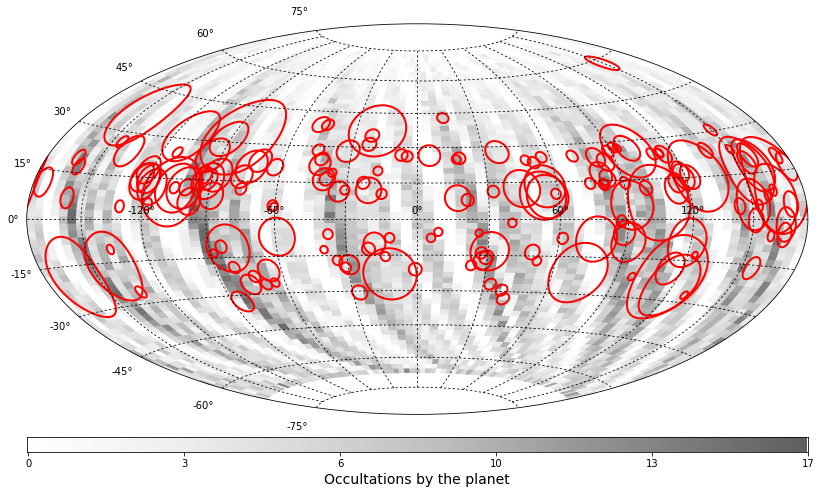

In [10]:

projection = 'Hammer'
n_bins = 80

cmap = plt.cm.Greys # plt.cm.copper
fraction_of_colorbar = 0.7
circle_color = 'r'
radius = 1.0*np.tan(transit_params.rp)

fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())

# Plot completeness
for i in range(n_bins-1):
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]
    for j in range(n_bins-1):
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]
        
        # [lon min, lon max], [lat min, lat min], [lat max]
        ax.fill_between([lon_bin_lower, lon_bin_upper], 
                        [lat_bin_lower, lat_bin_lower], 
                        lat_bin_upper, 
                        color=cmap(color_scale(bins[j, i])))
ax2 = plt.subplot(212)
plot_colorbar(fig, ax2)
fig.subplots_adjust(hspace=-0.58)

# Plot xsede solution circles
custom_grid(ax, color='k')

for s in filtered_spots:
    add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                     facecolor='none', edgecolor=circle_color, lw=2,
                     alpha=1.0, n_points=50)
ax2.set_xlabel('Occultations by the planet', fontsize=14)
#fig.savefig('plots/map_stsp.png', bbox_inches='tight', dpi=200)

In [ ]:
projection = 'Hammer'
n_bins = 80

def plot_colorbar(fig, ax):
    gradient = np.linspace(0, fraction_of_colorbar, 256)
    gradient = np.vstack(10*[gradient])

    ax.imshow(gradient.T, origin='lower', cmap=cmap, aspect=1, vmin=0, vmax=1)  # 
    ax.set_xticks([])
    nticks = 6
    axspace = np.linspace(0, 256, nticks)
    xticks = np.linspace(bins.min(), bins.max(), nticks).astype(int)
    ax.set_yticks(axspace)
    ax.set_yticklabels(xticks)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")

fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(111, projection=projection.lower())

# Plot completeness
for i in range(n_bins-1):
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]
    for j in range(n_bins-1):
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]
        
        # [lon min, lon max], [lat min, lat min], [lat max]
        ax.fill_between([lon_bin_lower, lon_bin_upper], 
                        [lat_bin_lower, lat_bin_lower], 
                        lat_bin_upper, 
                        color=cmap(color_scale(bins[j, i])), zorder=-50)

#ax2 = plt.subplot(212)
# Left bottom width height
#ax2 = fig.add_axes([0.72, 0.46, 0.18, 0.5])
ax2 = fig.add_axes([0.88, 0.35, 0.1, 0.3])
plot_colorbar(fig, ax2)

# Plot xsede solution circles
custom_grid(ax, color='k')

for s in filtered_spots:
    if s.name.startswith('window044'):
        add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                         facecolor='none', edgecolor='r', lw=4,
                         alpha=1, n_points=50, zorder=20)
        add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                         facecolor='r', edgecolor='none', lw=4,
                         alpha=0.4, n_points=50, zorder=20)
    elif s.name.startswith('window063'):
        add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                         facecolor='none', edgecolor='#0093FF', lw=4,
                         alpha=1, n_points=50, zorder=20)
        add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                         facecolor='#0093FF', edgecolor='none', lw=4,
                         alpha=0.4, n_points=50, zorder=20)
    elif s.name.startswith('window071'):
        add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                         facecolor='none', edgecolor='#00af43', lw=4,
                         alpha=1, n_points=50, zorder=20)
        add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                         facecolor='#00af43', edgecolor='none', lw=4,
                         alpha=0.4, n_points=50, zorder=20)
    else: 
        add_circle_patch(ax, s.r, np.pi/2 - s.theta, s.phi, 
                         facecolor='none', edgecolor='k', lw=2,
                         alpha=1.0, n_points=50)
ax2.set_ylabel('Occultations by the planet', fontsize=14)
fig.savefig('plots/map_stsp.png', bbox_inches='tight', dpi=200)
fig.savefig('plots/map_stsp.pdf', bbox_inches='tight', dpi=200)